In [1]:
#Notebook by Martijn de Vries
#martijndevries91@gmail.com

#This notebook contains the 'pulsar filament search' code. The goal is to spot narrow, linear features in 
#X-ray event data by plotting the number of counts in a box rotating around a center point
#This code assumes CIAO is running in the terminal the notebook was started from (to run 'dmcopy')
#As well as the following packages
import numpy as np
from astropy.io import fits
import subprocess
import os
from matplotlib import pyplot as plt

In [2]:
#First load in data
src = 'j2030'
src_img = 'j2030_14827_img.fits'

ihdr =  fits.open(src_img)[0].header
idat = fits.open(src_img)[0].data

#Load in exposure map
src_exp = 'j2030_14827_exp.fits'

edat = fits.open(src_exp)[0].data
ehdr = fits.open(src_exp)[0].header

#maximum number of counts/pix that you wish to include in the data. All pixels with more counts than this number
#get filtered out and ignored 
mc = 4 
mask_dat = np.ones(idat.shape)
mask_dat[idat > mc] = 0
idat[idat > mc] = 0
edat[idat > mc] = 0

#map of which pixels have been masked
#this is used to determine counts/pixel later on
#this assumes the exposure correcton is similar throughout the field
#if the boxes cross chip gaps, an exposure map should be used instead rather than directly comparing counts
mask_hdu = fits.PrimaryHDU(mask_dat, header=ihdr)
mask_img =  src + '_mask.fits'

#filtered image to be used
mask_hdu.writeto(mask_img, overwrite=True)

hdu_filt = fits.PrimaryHDU(idat, header=ihdr)
filt_img = src + '_filt_img.fits'
hdu_filt.writeto(filt_img, overwrite=True)

hdu_efilt = fits.PrimaryHDU(edat, header=ehdr)
filt_exp = src + '_filt_exp.fits'
hdu_efilt.writeto(filt_exp, overwrite=True)

In [3]:
#PSR coordinates (usae sky coords, for dmcopy)
cpx = 4080.88
cpy = 4088.13

#box length and width (in sky coords, adjust as necessary)
blen = 420
bwidth = 20

#how many pixels away from the PSR should the box start (you don't want to include PSR counts)
bdist = 10

#make directory to save the region files in 
dirname = './search_regs'
if os.path.isdir(dirname) == False: os.mkdir(dirname)

#use steps of 1 degree, adjust as necessary
for i in range(360):
    rd = i * np.pi/180
    
    #calculate center coords of the box
    bsh = blen/2 + bdist
    xc = cpx  - bsh*np.sin(rd)
    yc = cpy  - bsh*np.cos(rd)

    #construct region file (which you can load in ds9 and use with dmcopy)
    boxstr = 'box(' + str(xc) + ',' + str(yc) + ',' + str(blen) + ',' + str(bwidth) + ',' +str(float(360-(i+90))) + ') \n'
    
    #label regions to fit with astronomical conventions
    #(ie, reg0 will be pointed N, reg90 will be pointed E, reg180 will be S, etc)
    qr = 180-i
    if qr < 0: qr += 360
    fname = dirname + '/rbox_deg' + str(qr) + '.reg'
    f = open(fname, 'w')
    f.write('# Region file format: DS9 version 4.1 \n')
    f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1' \
            + ' move=1 delete=1 include=1 source=1 \n')
    f.write('physical \n')
    f.write(boxstr)
    f.close()

In [4]:
#loop over each of the regions, dmcopy, and calculate the number of counts

ddeg = 2 #how far should the data points be spaced out 
angle = np.arange(0, 360, ddeg)
ndat= len(angle)
cnts_arr, exp_arr, pix_arr = np.zeros(ndat),  np.zeros(ndat),  np.zeros(ndat)

for j,i in enumerate(angle):
    if i%30==0:print(i)
    fname = dirname + '/rbox_deg' + str(i) + '.reg'
    
    cmd = ['dmcopy', filt_img + '[(x,y)=region(' + fname + ')]', 'tmp_0.fits', 'clobber=yes']
    p = subprocess.call(cmd)
    
    cmd = ['dmcopy', filt_exp + '[(x,y)=region(' + fname + ')]', 'exptmp_0.fits', 'clobber=yes']
    p = subprocess.call(cmd)
    
    
    tdat = fits.open('tmp_0.fits')[0].data

    #get total number of counts 
    cnts = np.sum(tdat)
    cnts_arr[j] = cnts
    
    #get total exposure map value
    exdat = fits.open('exptmp_0.fits')[0].data
    exp_arr[j] = np.sum(exdat)
    
    pix = len(np.where(exdat != 0)[0])
    pix_arr[j] = pix
os.remove('tmp_0.fits')
os.remove('exptmp_0.fits')

0
30
60
90
120
150
180
210
240
270
300
330


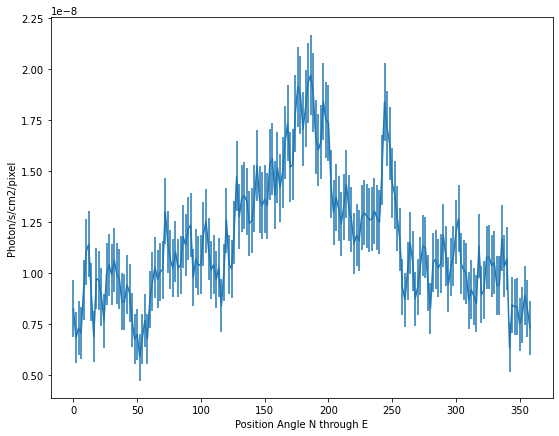

In [5]:
#now plot the resulting figure

fig, ax = plt.subplots(figsize=(9, 7))

sb_arr = cnts_arr/exp_arr
sb_earr = np.sqrt(cnts_arr)/exp_arr
ax.errorbar(angle, sb_arr, yerr=sb_earr)

ax.set_ylabel('Photon/s/cm2/pixel')
ax.set_xlabel('Position Angle N through E')

plt.savefig(src + '_filsearch.pdf', dpi=150)
plt.show()


In [9]:
#Write out data in a simple table file

fs_dat = np.zeros((ndat,5))
fs_dat[:,0] = angle
fs_dat[:,1] = sb_arr
fs_dat[:,2] = sb_earr
fs_dat[:,3] = cnts_arr
fs_dat[:,4] = pix_arr

blen_as = str(np.round(blen * 0.492, 1))
bwidth_as = str(np.round(bwidth * 0.492, 1))
bdist_as = str(np.round(bdist * 0.492, 1))
bname = src + '_filsearch.txt'
hdr =  src + ' PA - SB profile (Position angle N through E) \n'
hdr += 'Region: rectangle ' + blen_as + ' by ' + bwidth_as + ' arcsec, ' + bdist_as + ' arcsec away from PSR \n'
hdr += 'PA (degrees) |SB [photon/s/cm2/pix] | SB err | counts | area [pix] '
np.savetxt(bname, fs_dat, fmt=['%.1i', '%.4e' , '%.4e', '%.1i', '%.1i'], header=hdr)

[500. 502. 503. 507. 508. 508. 514. 502. 523. 527. 523. 526. 527. 525.
 527. 525. 534. 524. 524. 525. 524. 525. 525. 527. 530. 525. 525. 524.
 526. 523. 526. 526. 525. 523. 525. 530. 528. 522. 531. 524. 523. 527.
 526. 524. 525. 525. 526. 524. 521. 525. 523. 523. 535. 527. 525. 527.
 524. 527. 524. 526. 526. 522. 524. 524. 526. 525. 525. 527. 526. 525.
 525. 525. 525. 524. 522. 525. 525. 525. 527. 525. 528. 528. 527. 509.
 525. 524. 526. 526. 525. 525. 525. 523. 525. 522. 526. 525. 524. 526.
 528. 523. 525. 523. 527. 524. 525. 525. 525. 525. 527. 524. 524. 522.
 526. 523. 522. 525. 526. 525. 525. 529. 526. 526. 528. 526. 524. 520.
 522. 526. 509. 526. 526. 527. 527. 526. 525. 525. 525. 527. 529. 524.
 523. 525. 529. 524. 523. 527. 525. 527. 526. 526. 526. 524. 526. 525.
 524. 525. 529. 523. 525. 527. 525. 524. 525. 524. 524. 526. 525. 525.
 525. 524. 520. 524. 525. 525. 514. 514. 509. 502. 503. 501.]
